In [1]:
!pip install matplotlib
!pip install torch-tensorrt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 44.4 MB/s eta 0:00:00
  Created wheel for tensorrt: filename=tensorrt-10.12.0.36-py2.py3-none-any.whl size=46638 sha256=cf7730033d94cd36c6c1faf86a466ba4d3df5c9867f307ec66b7689f5b2498af
  Stored in directory: /root/.cache/pip/wheels/0e/d5/2f/cc5e3e56d49c61a02a7a8313f37db27d9af00e7f3463ed33e7
  Created wheel for tensorrt_cu12: filename=tensorrt_cu12-10.12.0.36-py2.py3-none-any.whl size=17480 sha256=b5a2f97e99892de0b2c87586a285a36f6b9725457e33c029a9d1a970c050a376
  Stored in directory: /root/.cache/pip/wheels/76/f7/e4/64a0965dcc74c067cee07482ef03cc18add0def626fb0ebc

In [2]:
import torch
print(torch.__version__)

2.8.0+cu126


# Transformer Model

In [ ]:
import time
import torch
from transformers import AutoTokenizer, AutoModel
import torch_tensorrt

# 1. Load model & tokenizer
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).eval().cuda()

# 2. Example batch of sentences
text = """ A good story encourages us to turn the next page and read more. We want to find out what happens next and what the main characters do and what they say to each other.
We may feel excited, sad, afraid, angry or really happy. This is because the experience of reading or listening to a story is much more likely to make us 'feel' that we are part
of the story, too. Just like in our 'real' lives, we might love or hate different characters in the story. Perhaps we recognise ourselves or others in some of them. Perhaps we
have similar problems. Because of this natural empathy with the characters, our brains process the reading of stories differently from the way we read factual information.
Our brains don't always recognise the difference between an imagined situation and a real one so the characters become 'alive' to us. What they say and do is therefore more meaningful.
This is why the words and structures that relate a story's events, descriptions and conversations are processed in this deeper way. In fact, cultures all around the world have always
used storytelling to pass knowledge from one generation to another. Our ancestors understood very well that this was the best way to make sure our histories and information about
how to relate to others and to our world was not only understood, but remembered too. (Notice that the word ‘history’ contains the word ‘story’ – More accurately, the word ‘story’
derives from ‘history’.) Encouraging your child to read or listen to stories should therefore help them to learn a second language in a way that is not only fun, but memorable.
Let's take a quick look at learning vocabulary within a factual text or within a story. Imagine the readers are eight-year-olds interested in animals. In your opinion, are they more
likely to remember AND want to continue reading the first or second text? """

texts = [item.strip() for item in text.split(".")][:16]  # adjust batch size here
inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=32).to("cuda")

input_ids = inputs["input_ids"].to(torch.int32)
attention_mask = inputs["attention_mask"].to(torch.int32)


# Run Baseline

In [20]:
# 3. Baseline PyTorch inference
with torch.no_grad():
    start = time.time()
    baseline_outputs = model(input_ids, attention_mask)
    torch.cuda.synchronize()
    end = time.time()
    baseline_time = end - start
    print(f"PyTorch latency: {baseline_time:.4f} sec")

print("Output shape (PyTorch):", baseline_outputs.last_hidden_state.shape)

PyTorch latency: 0.0433 sec
Output shape (PyTorch): torch.Size([16, 32, 768])


# Convert Pytorch Model into TensorRT

In [5]:
# 4. Convert model with Torch-TensorRT with enabled_precision of torch.float16
trt_model_float16 = torch_tensorrt.compile(
    model,
    inputs=[
        torch_tensorrt.Input(min_shape=[1, 32], opt_shape=[8, 32], max_shape=[16, 32], dtype=torch.int32),  # input_ids
        torch_tensorrt.Input(min_shape=[1, 32], opt_shape=[8, 32], max_shape=[16, 32], dtype=torch.int32),  # attention_mask
    ],
    enabled_precisions={torch.float16},
)

trt_inputs = {
    "input_ids": input_ids,
    "attention_mask": attention_mask
}

print("Convert to TensorRT.")

W0928 05:51:50.352000 1173 torch/fx/experimental/symbolic_shapes.py:6823] _maybe_guard_rel() was called on non-relation expression Eq(s43, 1) | Eq(s72, s43)


Convert to TensorRT.


In [18]:
# run model trt_model_float16
start = time.time()
trt_outputs_float16 = trt_model_float16(**trt_inputs)
torch.cuda.synchronize()
end = time.time()
trt_time_float16 = end - start
print(f"Torch-TensorRT latency: {trt_time_float16:.4f} sec")

print("Output shape (TensorRT):", trt_outputs_float16.last_hidden_state.shape)

Torch-TensorRT latency: 0.0095 sec
Output shape (TensorRT): torch.Size([16, 32, 768])


In [9]:
# 4. Convert model with Torch-TensorRT with enabled_precision of torch.float32
trt_model_float32 = torch_tensorrt.compile(
    model,
    inputs=[
        torch_tensorrt.Input(min_shape=[1, 32], opt_shape=[8, 32], max_shape=[16, 32], dtype=torch.int32),  # input_ids
        torch_tensorrt.Input(min_shape=[1, 32], opt_shape=[8, 32], max_shape=[16, 32], dtype=torch.int32),  # attention_mask
    ],
    enabled_precisions={torch.float32},
)

trt_inputs_float32 = {
    "input_ids": input_ids,
    "attention_mask": attention_mask
}


W0928 05:53:08.799000 1173 torch/fx/experimental/symbolic_shapes.py:6823] _maybe_guard_rel() was called on non-relation expression Eq(s43, 1) | Eq(s72, s43)


In [19]:
# run model trt_model_float32
start = time.time()
trt_outputs_float32 = trt_model_float32(**trt_inputs_float32)
torch.cuda.synchronize()
end = time.time()
trt_time_float32 = end - start
print(f"Torch-TensorRT latency: {trt_time_float32:.4f} sec")

print("Output shape (TensorRT):", trt_outputs_float32.last_hidden_state.shape)

Torch-TensorRT latency: 0.0405 sec
Output shape (TensorRT): torch.Size([16, 32, 768])


# Analysis

## Inference numerical difference

In [14]:
import torch

diff_tensor_float16 = torch.abs(baseline_outputs.last_hidden_state - trt_outputs_float16.last_hidden_state)

max_diff_float16 = diff_tensor_float16.max().item()
min_diff_float16 = diff_tensor_float16.min().item()

# 2️⃣ Percentage of elements > 0.1
threshold = 0.01
percent_over_threshold_float16 = (diff_tensor_float16 > threshold).float().mean().item() * 100

print(f"Max absolute difference: {max_diff_float16}")
print(f"Min absolute difference: {min_diff_float16}")
print(f"Percentage of elements > {threshold}: {percent_over_threshold_float16:.3f}%")


Max absolute difference: 0.05847358703613281
Min absolute difference: 0.0
Percentage of elements > 0.01: 0.109%


In [15]:
import torch

diff_tensor_float32 = torch.abs(baseline_outputs.last_hidden_state - trt_outputs_float32.last_hidden_state)

max_diff_float32 = diff_tensor_float32.max().item()
min_diff_float32 = diff_tensor_float32.min().item()

threshold = 0.0001
percent_over_threshold_float32 = (diff_tensor_float32 > threshold).float().mean().item() * 100

print(f"Max absolute difference: {max_diff_float32}")
print(f"Min absolute difference: {min_diff_float32}")
print(f"Percentage of elements > {threshold}: {percent_over_threshold_float32:.3f}%")

Max absolute difference: 1.2874603271484375e-05
Min absolute difference: 0.0
Percentage of elements > 0.0001: 0.000%


## Inference time difference

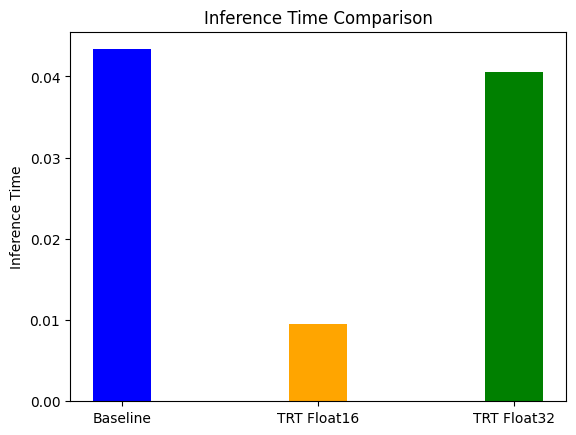

In [22]:
import matplotlib.pyplot as plt

inference_time = [baseline_time, trt_time_float16, trt_time_float32]
labels = ['Baseline', 'TRT Float16', "TRT Float32"]

plt.bar(labels, inference_time, width=0.3, color=['blue', 'orange', 'green'])

# Adding labels and title
plt.ylabel('Inference Time')
plt.title('Inference Time Comparison')

# Display the plot
plt.show()



In [24]:
import pandas as pd
import numpy as np

data = pd.DataFrame({"Inference_time": [baseline_time, trt_time_float16, trt_time_float32],
                     "Inference_max_difference": [np.nan, max_diff_float16, max_diff_float32],
                     "Infernce_Above_threshold_percentage (0.01)": [np.nan, percent_over_threshold_float16, percent_over_threshold_float32]})

data['Configure'] = ['Pytorch baseline', "TensorRT float16", "TensorRT float32"]
data = data.set_index('Configure')
data

,Inference_time,Inference_max_difference,Infernce_Above_threshold_percentage (0.01)
Configure,,,
Pytorch baseline,0.043350,NaN,NaN
TensorRT float16,0.009505,0.058474,0.108846
TensorRT float32,0.040543,0.000013,0.000000


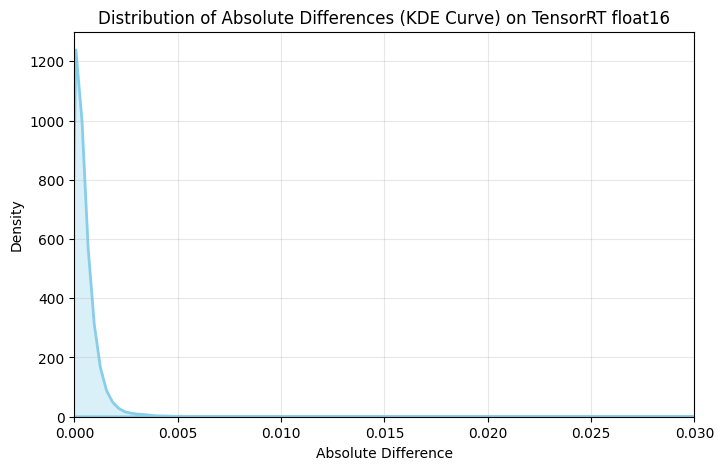

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

diff_flat_float16 = diff_tensor_float16.flatten().cpu().numpy()

plt.figure(figsize=(8, 5))
sns.kdeplot(diff_flat_float16, label="TensorRT_float16", fill=True, color="skyblue", alpha=0.3, linewidth=2)

plt.xlim(0, 0.03)
plt.xlabel("Absolute Difference")
plt.ylabel("Density")
plt.title("Distribution of Absolute Differences (KDE Curve) on TensorRT float16")
plt.grid(alpha=0.3)
plt.show()